In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import *
from qiskit.quantum_info import state_fidelity
import numpy as np
import matplotlib.pylab as plt
from qiskit.quantum_info import DensityMatrix

In [2]:
def circuit(params,shots,target_state):

    n_qubits = len(params)
    layers = len(params[0])
    qc = QuantumCircuit(n_qubits)
    
    for layer in range(layers):
        for qubit in range(n_qubits):
            qc.rx(params[qubit][layer][0],qubit)
            qc.ry(params[qubit][layer][1],qubit)
        if(layer<1):
            qc.cx(0,1)
            qc.cx(1,0)  
  
    backend_sim = Aer.get_backend('statevector_simulator')
    job_sim = execute(qc, backend_sim, shots=shots)
    result_sim = job_sim.result()
    state_vector = DensityMatrix(result_sim.get_statevector(qc))
    fid = state_fidelity(state_vector,target_state)
    return fid

In [3]:
def cost(params,shots,target_state):
    
    res=1-circuit(params,shots,target_state)

    return res

Quantum Gradient:

\begin{align}
  \frac{df}{d\theta }\,=\,\frac{1}{2}\,\left( f\left(\theta +\frac{\pi }{2} \right)-f\left(\theta -\frac{\pi }{2} \right) \right)\\ \\
\end{align}

$\theta$ is the weights and $f$ is quantum unitary gate. 

In [4]:
def gradient(params,shots,target_state):

    g = np.zeros(params.shape)
    
    for qubit in range(len(params)):
        
        for layer in range(len(params[qubit])):
            
            for val in range(len(params[qubit][layer])):
                        
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                F1 = cost(params,shots,target_state)
                
                params[qubit][layer][val] = params[qubit][layer][val]-np.pi
                    
                F2 = cost(params,shots,target_state)
                
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                g[qubit][layer][val] = (F1-F2)/2
    return g

In [5]:
def optimize(params,shots,target_state,lr):
    g = gradient(params,shots,target_state)
    params = params - (lr*g)
    return params

In [6]:
np.random.seed(100) #to be reproducible 
params = np.random.rand(2,2,2) #(n_qubits,n_layers,n_weights)
target_state=DensityMatrix(np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]))
shots=100
loss = np.inf
lr = 0.2
test_loss = []
epochs = 200
#print(params)
for it in range(epochs):
    
    params = optimize(params,shots,target_state,lr)
    res = cost(params,shots,target_state)
    test_loss.append(res)
#    print(params)

    # save best weights based on testing portion of the data    
    if res < loss:
        loss = res
        var = params
    print("Epoch: {:2d} | testing loss: {:4f}".format(it+1,res))

Epoch:  1 | testing loss: 0.572495
Epoch:  2 | testing loss: 0.535208
Epoch:  3 | testing loss: 0.498631
Epoch:  4 | testing loss: 0.463156
Epoch:  5 | testing loss: 0.429077
Epoch:  6 | testing loss: 0.396584
Epoch:  7 | testing loss: 0.365774
Epoch:  8 | testing loss: 0.336673
Epoch:  9 | testing loss: 0.309252
Epoch: 10 | testing loss: 0.283454
Epoch: 11 | testing loss: 0.259205
Epoch: 12 | testing loss: 0.236431
Epoch: 13 | testing loss: 0.215065
Epoch: 14 | testing loss: 0.195050
Epoch: 15 | testing loss: 0.176339
Epoch: 16 | testing loss: 0.158895
Epoch: 17 | testing loss: 0.142686
Epoch: 18 | testing loss: 0.127685
Epoch: 19 | testing loss: 0.113861
Epoch: 20 | testing loss: 0.101183
Epoch: 21 | testing loss: 0.089614
Epoch: 22 | testing loss: 0.079111
Epoch: 23 | testing loss: 0.069626
Epoch: 24 | testing loss: 0.061104
Epoch: 25 | testing loss: 0.053485
Epoch: 26 | testing loss: 0.046705
Epoch: 27 | testing loss: 0.040699
Epoch: 28 | testing loss: 0.035400
Epoch: 29 | testing 

[9.57122673e-07-4.36567087e-06j 1.49279966e-01-6.91165165e-01j
 1.49281816e-01-6.91173745e-01j 9.33014519e-07-4.37641468e-06j]


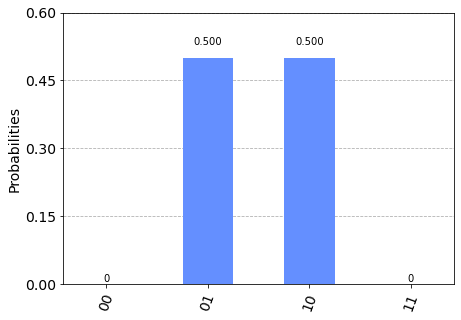

In [9]:
#testing the model
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
params=var
n_qubits = len(params)
layers = len(params[0])
qc = QuantumCircuit(n_qubits) 
for layer in range(layers):
    for qubit in range(n_qubits):
        qc.rx(params[qubit][layer][0],qubit)
        qc.ry(params[qubit][layer][1],qubit)    
    if(layer<1):
        qc.cx(0,1)
        qc.cx(1,0)  

backend_sim = Aer.get_backend('statevector_simulator')
job = execute(qc, backend_sim, shots=1000)
state_vector = job.result().get_statevector(qc)
print(state_vector)
counts = job.result().get_counts()
plot_histogram(counts)

Note:
Although the final state vector has some phase, it can be approximated as a global phase and hence, neglegted, leaving behind the required state.